# Logistic Regression for Rainfall Data

In [41]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

## Load the data and perform EDA

In [5]:
load_dotenv()
kaggle_data_dir = os.getenv("KAGGLE_DATA_DIR")
data_path = os.path.join(kaggle_data_dir, '05.03-rainfall')

In [6]:
train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_path, 'test.csv'))

In [60]:
train_data.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


### Histograms grouped by rainfall for all features

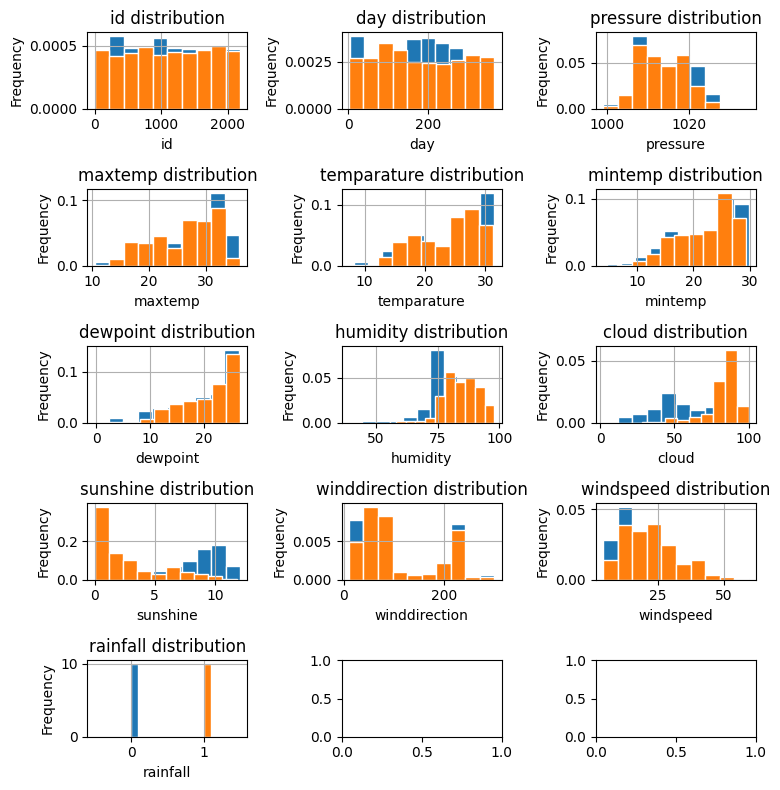

In [9]:
# Initialize a 5x3 charts
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8, 8))

# Flatten the axes array (makes it easier to iterate over)
axes = axes.flatten()

# Loop through each column and plot a histogram
for i, column in enumerate(train_data.columns):
    
    # Add the histogram
    train_data.groupby('rainfall')[column].hist(ax=axes[i], # Define on which ax we're working on
                    edgecolor='white', # Color of the border
                    density=True, # Normalize the data
                    # color='#69b3a2' # Color of the bins
                   )
    
    # Add title and axis label
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Frequency') 

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Preprocess the training data

In [26]:
# Separate features (X) and target (y)
X = train_data.iloc[:,2:-1]
X = (X - X.mean()) / X.std()
y = train_data.iloc[:, -1]

## Train the Logistic Regression model

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train)

## Evaluate the model

In [64]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Score: {auc_roc:.4f}")

Accuracy: 0.865296803652968
Confusion Matrix:
 [[ 67  41]
 [ 18 312]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.62      0.69       108
           1       0.88      0.95      0.91       330

    accuracy                           0.87       438
   macro avg       0.84      0.78      0.80       438
weighted avg       0.86      0.87      0.86       438

Cross-validation scores: [0.84931507 0.8652968  0.89041096 0.86757991 0.85388128]
Mean accuracy: 0.8653
AUC-ROC Score: 0.7829


## Visualize Feature Importance

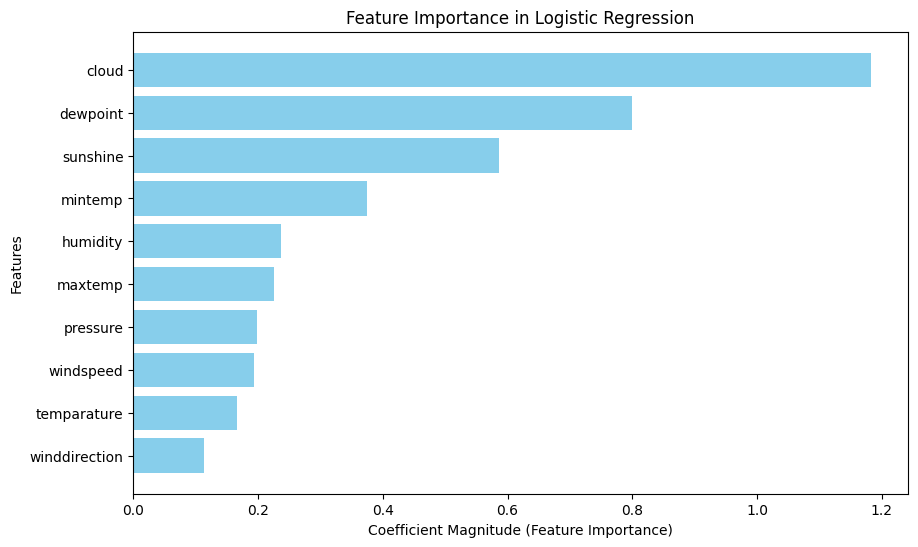

In [65]:
# Extract coefficients and feature names
feature_importance = np.abs(model.coef_).flatten()  # Absolute values of coefficients
feature_names = X_train.columns  # Feature names

# Sort by importance
sorted_indices = np.argsort(feature_importance)[::-1]  # Descending order
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importance = feature_importance[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Coefficient Magnitude (Feature Importance)")
plt.ylabel("Features")
plt.title("Feature Importance in Logistic Regression")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

# Create Submission

In [66]:
test_data.head()
X_submission = test_data.iloc[:,2:]
# mean interpolate missing
X_submission = X_submission.fillna(X_submission.mean())
# Normalize the test data
X_submission = (X_submission - X_submission.mean()) / X_submission.std()

In [53]:
y_submission = model.predict_proba(X_submission)

In [55]:
submission = pd.DataFrame({
    'id': test_data['id'],  # Assuming 'id' is the first column in test_data
    'rainfall': y_submission[:, 1]  # Probability of rainfall
})

In [59]:
submission.to_csv(
    'logreg-submission.csv', 
    index=False)

In [61]:
import subprocess
subprocess.run(["kaggle", "competitions", "submit", "-c", "playground-series-s5e3", "-f", "logreg-submission.csv", "-m", "Logistic Regression"])

100%|██████████| 17.2k/17.2k [00:00<00:00, 54.4kB/s]


Successfully submitted to Binary Prediction with a Rainfall Dataset

CompletedProcess(args=['kaggle', 'competitions', 'submit', '-c', 'playground-series-s5e3', '-f', 'logreg-submission.csv', '-m', 'Logistic Regression'], returncode=0)